In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q -U keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization


In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split

# Load the dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Convert labels to one-hot encoding for test set to work with categorical cross entropy
y_test = to_categorical(y_test, num_classes=10)

#80:20 split with the data
validation_ratio = 0.2

# Split data into new training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=validation_ratio, random_state=42)

# Convert labels to one-hot encoding for training and validation sets
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)

# Scale the pixel values to range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Check shapes
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
x_train shape: (40000, 32, 32, 3)
y_train shape: (40000, 10)
x_val shape: (10000, 32, 32, 3)
y_val shape: (10000, 10)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 10)


First trial of resnet 18 model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model

# Residual Block
def residual_req_block(x, filters, kernel_size=3, stride=1, downsample=False):
    shortcut = x

    # First Conv layer
    x = Conv2D(filters, kernel_size=kernel_size,
    strides=stride, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second Conv layer
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    # Downsampling the shortcut if needed
    if downsample:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same', kernel_initializer='he_normal')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Adding the shortcut to the main path
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

def resnet18_model(input_shape=(32, 32, 3), num_classes=10):
    inputs = Input(shape=input_shape)

    # Initial Conv layer
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Residual Blocks
    x = residual_req_block(x, 64)
    x = residual_req_block(x, 64)

    x = residual_req_block(x, 128, stride=2, downsample=True)
    x = residual_req_block(x, 128)

    x = residual_req_block(x, 256, stride=2, downsample=True)
    x = residual_req_block(x, 256)

    x = residual_req_block(x, 512, stride=2, downsample=True)
    x = residual_req_block(x, 512)

    # Global Average Pooling and Dense output layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Creating the model
    model = Model(inputs, outputs)

    return model

resnet18_model = resnet18_model()
resnet18_model.compile(optimizer='adam',
            loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
resnet18_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 32, 32, 64)     │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 32, 32, 64)     │            256 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_17             │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ activation_17[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 32, 32, 64)     │            256 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ activation_18[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 32, 32, 64)     │            256 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ activation_17[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 32, 32, 64)     │              0 │ add_8[0][0]            │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ activation_19[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_23    │ (None, 32, 32, 64)     │            256 │ conv2d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)   

 Total params: 11,188,362 (42.68 MB)

 Trainable params: 11,178,762 (42.64 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Deep Learning Uni/resnet18_model.keras"
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=4,  # Stop if no improvement for 10 epochs
    mode='max',
    verbose=1,
    restore_best_weights=True
)

Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4492 - loss: 1.5530
Epoch 1: val_accuracy improved from -inf to 0.59010, saving model to /content/drive/MyDrive/Deep Learning Uni/resnet18_model.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 77s 48ms/step - accuracy: 0.4493 - loss: 1.5528 - val_accuracy: 0.5901 - val_loss: 1.2482
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7151 - loss: 0.7994
Epoch 2: val_accuracy improved from 0.59010 to 0.66010, saving model to /content/drive/MyDrive/Deep Learning Uni/resnet18_model.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 57s 46ms/step - accuracy: 0.7151 - loss: 0.7994 - val_accuracy: 0.6601 - val_loss: 1.0223
Epoch 3/100
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7942 - loss: 0.5949
Epoch 3: val_accuracy improved from 0.66010 to 0.75460, saving model to /content/drive/MyDrive/Deep Learning Uni/resnet18_model.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - accuracy: 0.7942 - loss: 0.5948 - val_accu

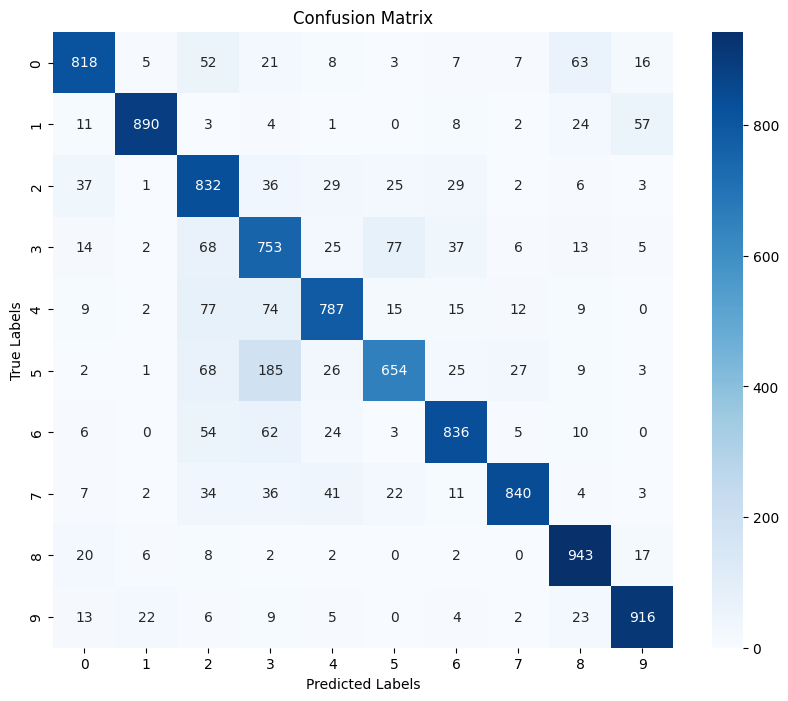

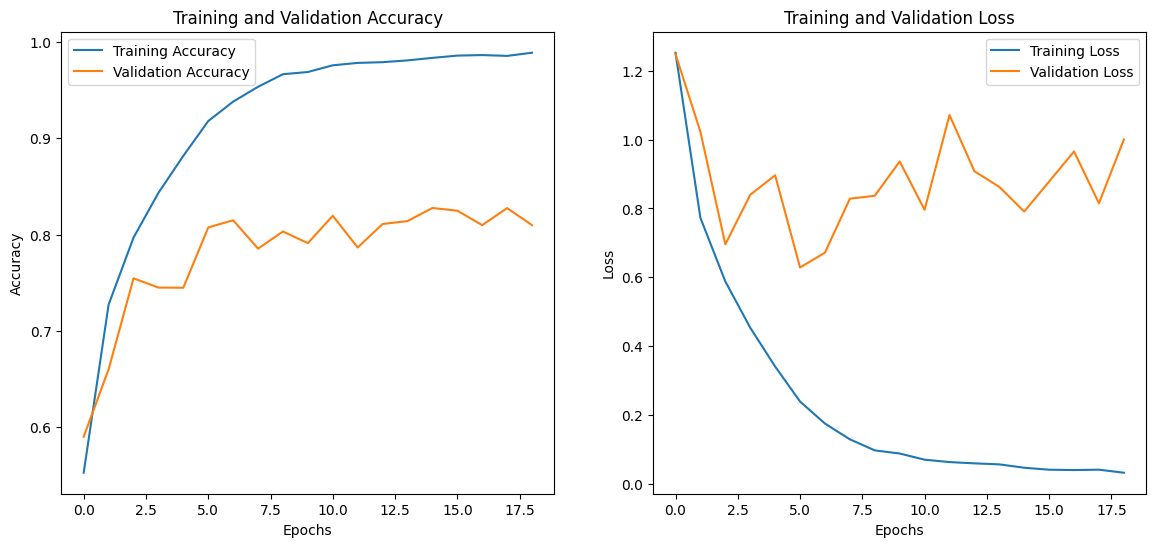

In [ ]:
import matplotlib.pyplot as plt

# Train the ResNet-18 model
history_resnet = resnet18_model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint, early_stopping],
    verbose=1
)


from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate on test data
test_loss, test_accuracy = resnet18_model.evaluate(x_test, y_test, verbose=1)
print(f"ResNet-18 Test accuracy: {test_accuracy}")

# Generate predictions and calculate the confusion matrix and classification report
y_pred = resnet18_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, digits=4))

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Plot training and validation accuracy and loss
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Training Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()



In [ ]:
alexnet